In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [9]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3UZJVS/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3UZJVS/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpceaugakptfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabe

In [10]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method = "nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method = "nearest")

    return input_image, input_mask

In [11]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [12]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [13]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [14]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls = tf.data.AUTOTUNE)

In [15]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

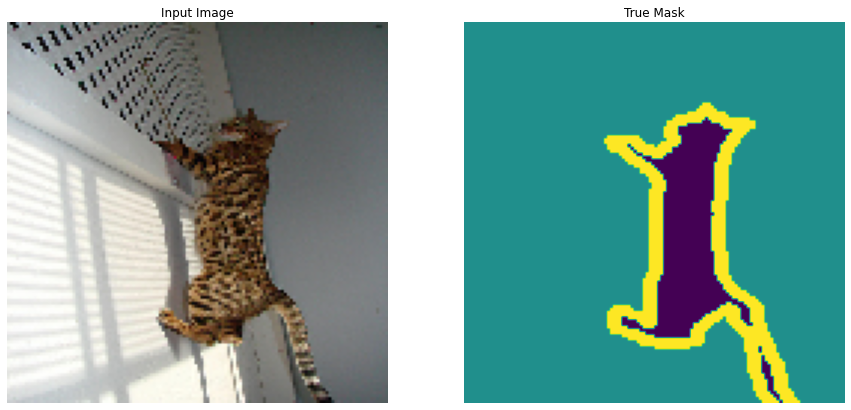

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [17]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [18]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [19]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [20]:
def build_unet_model():
    inputs = layers.Input(shape=(128,128,3))

    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = double_conv_block(p4, 1024)

    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [21]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [22]:
unet_model.compile(optimizer = tf.keras.optimizers.Adam(),
                   loss = "sparse_categorical_crossentropy",
                   metrics = "accuracy")

In [23]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs = NUM_EPOCHS,
                               steps_per_epoch = STEPS_PER_EPOCH,
                               validation_steps = VALIDATION_STEPS,
                               validation_data = test_batches)

Epoch 1/20
57/57 [==============================] - 91s 1s/step - loss: 1.0489 - accuracy: 0.5735 - val_loss: 0.8738 - val_accuracy: 0.5864
Epoch 2/20
57/57 [==============================] - 70s 1s/step - loss: 0.8089 - accuracy: 0.6250 - val_loss: 0.7303 - val_accuracy: 0.6781
Epoch 3/20
57/57 [==============================] - 64s 1s/step - loss: 0.6764 - accuracy: 0.7216 - val_loss: 0.6923 - val_accuracy: 0.7064
Epoch 4/20
57/57 [==============================] - 63s 1s/step - loss: 0.6259 - accuracy: 0.7489 - val_loss: 0.5719 - val_accuracy: 0.7766
Epoch 5/20
57/57 [==============================] - 63s 1s/step - loss: 0.5707 - accuracy: 0.7756 - val_loss: 0.5239 - val_accuracy: 0.7937
Epoch 6/20
57/57 [==============================] - 63s 1s/step - loss: 0.5307 - accuracy: 0.7924 - val_loss: 0.5152 - val_accuracy: 0.8033
Epoch 7/20
57/57 [==============================] - 63s 1s/step - loss: 0.4949 - accuracy: 0.8080 - val_loss: 0.5125 - val_accuracy: 0.7968
Epoch 8/20
57/57 [==

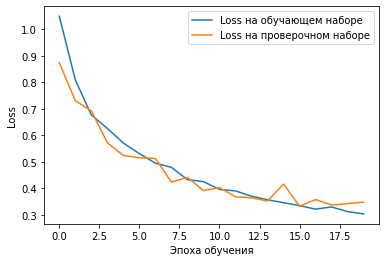

In [24]:
# Считаем графики потерь
import matplotlib.pyplot as plt

plt.plot(model_history.history['loss'], 
         label='Loss на обучающем наборе')
plt.plot(model_history.history['val_loss'], 
         label='Loss на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

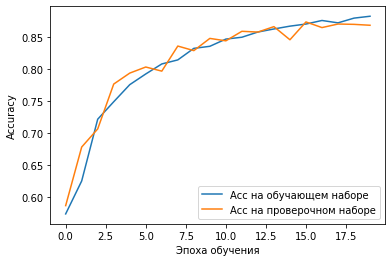

In [25]:
plt.plot(model_history.history['accuracy'], 
         label='Acc на обучающем наборе')
plt.plot(model_history.history['val_accuracy'], 
         label='Acc на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


1/1 [==============================] - 0s 16ms/step


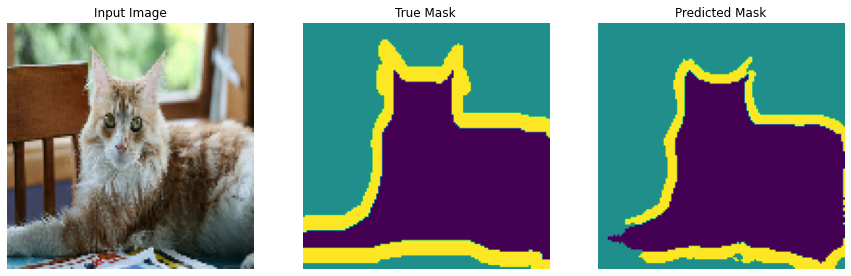

In [35]:
display([sample_image, sample_mask,
                 create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 18ms/step


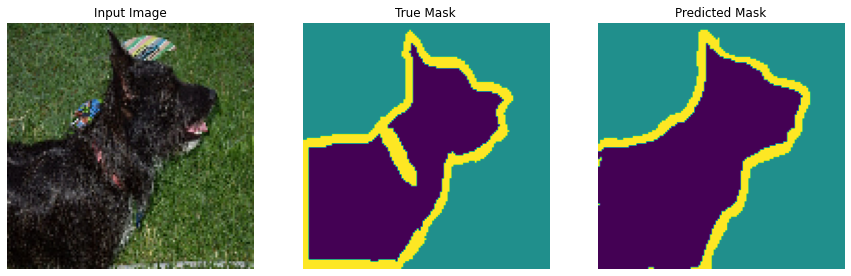

In [50]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])

sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
pred_mask = create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))
display([sample_image, sample_mask, pred_mask])